# ADNI Classification Model Final Project

### Group #13: Kezi Cheng, Nikhil Mallareddy, and Jonathan Fisher

Import libraries:

In [1]:
%matplotlib inline
from IPython.display import display
from IPython.display import Image
from sklearn import preprocessing
from sklearn.cross_validation import KFold
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.ensemble import RandomForestClassifier as RandomForest
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score  
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split  
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier 
from sklearn.tree import export_graphviz
from statsmodels.api import OLS
from statsmodels.tools import add_constant
import datetime
import matplotlib
import matplotlib.cm as cmx
import matplotlib.colors as colors
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import seaborn.apionly as sns
import sklearn.metrics as metrics
import statsmodels.api as sm
import sys
import urllib
import warnings

pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)

/Users/nikhil/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Data Loading, Cleaning, and EDA

Read in ADNIMERGE and CSF datasets:

In [2]:
adnimerge = pd.read_csv('ADNIMERGE.csv')
csf = pd.read_csv('UPENNBIOMK_MASTER.csv')

print(adnimerge.shape)
print(csf.shape)

(13017, 94)
(5876, 14)


Preliminary data cleaning:

CSF measurements are taken in multiple batches. The UPENN dataset includes the median of values across batches which serve as a good summary value for each patient/timepoint. We will use these median values for our analyses.

ADNIMERGE contains two variables near the end called 'Month' and 'M' which are identical to one another and are also redundant with VISCODE. Drop 'M' but keep 'Month' in case it is useful for parsing in longitudinal analysis. Also drop all variables with suffix '_bl' as these are redundant in our analysis since we are only looking at baseline data.

In [3]:
csf_bl = csf.loc[csf['VISCODE']=='bl'].loc[csf['BATCH']=='MEDIAN'] #baseline csf values
csf_bl = csf_bl.drop(['ABETA_RAW', 'TAU_RAW', 'PTAU_RAW'], axis=1) #drop raw data (use only scaled data)

adnimerge_bl = adnimerge.loc[adnimerge['VISCODE']=='bl'] #baseline adnimerge values

adnimerge_bl = adnimerge_bl.drop('M', axis=1)
adnimerge_bl = adnimerge_bl.drop(['EXAMDATE_bl', 'CDRSB_bl', 'ADAS11_bl', 'ADAS13_bl', 'MMSE_bl',
       'RAVLT_immediate_bl', 'RAVLT_learning_bl', 'RAVLT_forgetting_bl',
       'RAVLT_perc_forgetting_bl', 'FAQ_bl', 'Ventricles_bl',
       'Hippocampus_bl', 'WholeBrain_bl', 'Entorhinal_bl', 'Fusiform_bl',
       'MidTemp_bl', 'ICV_bl', 'MOCA_bl', 'EcogPtMem_bl', 'EcogPtLang_bl',
       'EcogPtVisspat_bl', 'EcogPtPlan_bl', 'EcogPtOrgan_bl',
       'EcogPtDivatt_bl', 'EcogPtTotal_bl', 'EcogSPMem_bl',
       'EcogSPLang_bl', 'EcogSPVisspat_bl', 'EcogSPPlan_bl',
       'EcogSPOrgan_bl', 'EcogSPDivatt_bl', 'EcogSPTotal_bl', 'FDG_bl',
       'AV45_bl', 'Years_bl', 'Month_bl'], axis=1)

Merge ADNIMERGE and CSF:

In [4]:
merged_dx = pd.merge(left=adnimerge_bl, right=csf_bl, left_on='RID', right_on='RID', how='left')

Our outcome of interest (autopsy-proven diagnosis) is stored in the column 'DX_bl'.

In [5]:
print("No. of missing values in 'DX_bl':", merged_dx['DX_bl'].isnull().sum())

No. of missing values in 'DX_bl': 45


Collapse dx_bl into 3 categories, coded as follows: 
- CN (CN+SMC) = 1
- MCI (LMCI+EMCI) = 2
- AD = 3

In [6]:
merged_dx['Base_DX']= merged_dx['DX_bl'].copy()
merged_dx.loc[merged_dx['DX_bl']=='SMC','Base_DX'] = 0
merged_dx.loc[merged_dx['DX_bl']=='CN','Base_DX'] = 0
merged_dx.loc[merged_dx['DX_bl']=='EMCI','Base_DX'] = 1
merged_dx.loc[merged_dx['DX_bl']=='LMCI','Base_DX'] = 1
merged_dx.loc[merged_dx['DX_bl']=='MCI','Base_DX'] = 1
merged_dx.loc[merged_dx['DX_bl']=='AD','Base_DX'] = 2

In [7]:
#confirm conversion
#merged_dx["Base_DX"].unique()

In [8]:
print('observations per protocol:')
merged_dx['COLPROT'].value_counts()

observations per protocol:


ADNI1     819
ADNI2     789
ADNIGO    131
ADNI3      45
Name: COLPROT, dtype: int64

We restrict our analysis to data collected via the ADNI2 protocol.

Extract ADNI2 data:

In [9]:
adnitwo = merged_dx.loc[merged_dx['COLPROT']=='ADNI2']
print('shape of extracted ADNI data: ', adnitwo.shape)

shape of extracted ADNI data:  (789, 68)


Drop columns with large proportion of missing values:

In [10]:
#drop 'FLDSTRENG' and 'FSVERSION' variables (unknown meaning and missing values)
adnitwo = adnitwo.drop(['FLDSTRENG', 'FSVERSION', 'FLDSTRENG_bl', 'FSVERSION_bl'], axis=1)

#drop PIB (not measured in ADNI2)
adnitwo = adnitwo.drop(['PIB', 'PIB_bl'], axis=1)

print('shape after dropping empty/sparse columns: ', adnitwo.shape)
print('\nNumber of missing values for remaining features:')
for col in adnitwo.columns:
    print(col, adnitwo[col].isnull().sum())

shape after dropping empty/sparse columns:  (789, 62)

Number of missing values for remaining features:
RID 0
PTID 0
VISCODE_x 0
SITE 0
COLPROT 0
ORIGPROT 0
EXAMDATE 0
DX_bl 0
AGE 0
PTGENDER 0
PTEDUCAT 0
PTETHCAT 0
PTRACCAT 0
PTMARRY 0
APOE4 11
FDG 15
AV45 23
CDRSB 0
ADAS11 4
ADAS13 6
MMSE 0
RAVLT_immediate 2
RAVLT_learning 2
RAVLT_forgetting 2
RAVLT_perc_forgetting 3
FAQ 6
MOCA 10
EcogPtMem 3
EcogPtLang 4
EcogPtVisspat 8
EcogPtPlan 5
EcogPtOrgan 24
EcogPtDivatt 11
EcogPtTotal 4
EcogSPMem 10
EcogSPLang 9
EcogSPVisspat 21
EcogSPPlan 18
EcogSPOrgan 40
EcogSPDivatt 26
EcogSPTotal 11
Ventricles 64
Hippocampus 89
WholeBrain 37
Entorhinal 108
Fusiform 108
MidTemp 108
ICV 14
DX 7
Month 0
update_stamp_x 0
VISCODE_y 85
BATCH 85
KIT 85
STDS 85
DRWDTE 85
RUNDATE 85
ABETA 85
TAU 102
PTAU 85
update_stamp_y 85
Base_DX 0


Rows with remaining missing values:

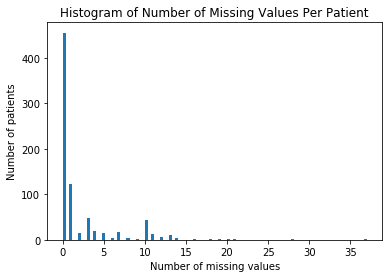

In [11]:
plt.hist(adnitwo.isnull().sum(axis=1), bins=100) #To find the number of missing datapoints in each row
plt.title('Histogram of Number of Missing Values Per Patient')
plt.xlabel("Number of missing values")
plt.ylabel("Number of patients")
plt.show()

Based on the histogram above, the majority of observations contain 0 missing values, but there is still a tail of observations containing some missing values. If we drop all observations with missing values, then the total number of observations remaining is:

In [12]:
adnitwo_full = adnitwo.dropna(axis='rows')
print('No. of observations without any missing values:', adnitwo_full.shape[0])

No. of observations without any missing values: 455


We can retain a larger proportion of observations by dropping only observations with ≥10 missing values and imputing remaining missing values.

In [13]:
threshold = adnitwo.shape[1] - 10
adnitwo_dropten = adnitwo.dropna(axis='rows', thresh=threshold) #thresh = min # of non-NaN values
print('Number of rows after dropping those with ≥10 NaNs:', adnitwo_dropten.shape[0])

Number of rows after dropping those with ≥10 NaNs: 747


In [14]:
print('\nNumbers of Missing Values per Feature After Removing Observations with ≥10 NaNs:')
for col in adnitwo.columns:
    print(col, adnitwo[col].isnull().sum())


Numbers of Missing Values per Feature After Removing Observations with ≥10 NaNs:
RID 0
PTID 0
VISCODE_x 0
SITE 0
COLPROT 0
ORIGPROT 0
EXAMDATE 0
DX_bl 0
AGE 0
PTGENDER 0
PTEDUCAT 0
PTETHCAT 0
PTRACCAT 0
PTMARRY 0
APOE4 11
FDG 15
AV45 23
CDRSB 0
ADAS11 4
ADAS13 6
MMSE 0
RAVLT_immediate 2
RAVLT_learning 2
RAVLT_forgetting 2
RAVLT_perc_forgetting 3
FAQ 6
MOCA 10
EcogPtMem 3
EcogPtLang 4
EcogPtVisspat 8
EcogPtPlan 5
EcogPtOrgan 24
EcogPtDivatt 11
EcogPtTotal 4
EcogSPMem 10
EcogSPLang 9
EcogSPVisspat 21
EcogSPPlan 18
EcogSPOrgan 40
EcogSPDivatt 26
EcogSPTotal 11
Ventricles 64
Hippocampus 89
WholeBrain 37
Entorhinal 108
Fusiform 108
MidTemp 108
ICV 14
DX 7
Month 0
update_stamp_x 0
VISCODE_y 85
BATCH 85
KIT 85
STDS 85
DRWDTE 85
RUNDATE 85
ABETA 85
TAU 102
PTAU 85
update_stamp_y 85
Base_DX 0


Mean imputation to fill in remaining missing values:

In [15]:
#list of column names for columns containing NaNs
cols_with_na=[]

for column in adnitwo_dropten:
    if adnitwo_dropten[column].isnull().any()==True:
        cols_with_na.append(column)

#impute means
meandf = adnitwo_dropten.copy()
for col in cols_with_na:
    if adnitwo_dropten[col].dtype=='float64':
        meandf[col] = adnitwo_dropten[col].fillna(adnitwo_dropten[col].mean())
    else: #for non-numeric data
        meandf[col] = adnitwo_dropten[col].fillna(adnitwo_dropten[col].mode()[0])

#confirm imputation success
#np.any(pd.isnull(meandf))  #If `False`, confirms that meandf is now Nan-free

## Feature Engineering

In [16]:
adnimerge.shape

(13017, 94)

### Adding time effects terms from 2-year follow-up (for exploratory purposes; not included in final models)

In [17]:
adnimerge[adnimerge['COLPROT']== 'ADNI2'].groupby('VISCODE').count()['RID']

VISCODE
bl      789
m03     673
m06     721
m102      7
m108    119
m114      1
m12     745
m120     72
m126      4
m18     594
m24     679
m30     263
m36     395
m42      55
m48     405
m54      20
m60     290
m66     161
m72     253
m78     208
m84     199
m90     129
m96     155
Name: RID, dtype: int64

- 679 of the total ADNI2 patients had a follow up visit at t= m24

In [18]:
adni2_m24_brainvol = adnimerge.loc[adnimerge['COLPROT']=='ADNI2'].loc[adnimerge['VISCODE'] == 'm24'][['RID','WholeBrain']]

In [19]:
adni2_m24_brainvol.head()

,RID,WholeBrain
59,5280,NaN
153,5277,980388.0
258,5273,902326.0
353,5272,NaN
434,5269,1147730.0


In [20]:
adni2_m24_brainvol.isnull().sum()

RID             0
WholeBrain    163
dtype: int64

- 163 of the people who went in for a visit at t=24m don't have whole brain vol data. 

In [21]:
#add a prefix to column name
adni2_m24_brainvol=adni2_m24_brainvol.add_prefix('m24_')  

In [22]:
#merge m24 brain vol data with meandf
merged_meandf_m24 = pd.merge(left=meandf, right=adni2_m24_brainvol, left_on='RID', right_on='m24_RID', how='left')

In [23]:
#checking number of cases with CN, MCI and AD
merged_meandf_m24['Base_DX'].value_counts()

1    330
0    278
2    139
Name: Base_DX, dtype: int64

## Preprocessing 

One-hot encode categorical variables for use as model predictors:

In [24]:
merged_meandf_m24.columns

Index(['RID', 'PTID', 'VISCODE_x', 'SITE', 'COLPROT', 'ORIGPROT', 'EXAMDATE',
       'DX_bl', 'AGE', 'PTGENDER', 'PTEDUCAT', 'PTETHCAT', 'PTRACCAT',
       'PTMARRY', 'APOE4', 'FDG', 'AV45', 'CDRSB', 'ADAS11', 'ADAS13', 'MMSE',
       'RAVLT_immediate', 'RAVLT_learning', 'RAVLT_forgetting',
       'RAVLT_perc_forgetting', 'FAQ', 'MOCA', 'EcogPtMem', 'EcogPtLang',
       'EcogPtVisspat', 'EcogPtPlan', 'EcogPtOrgan', 'EcogPtDivatt',
       'EcogPtTotal', 'EcogSPMem', 'EcogSPLang', 'EcogSPVisspat', 'EcogSPPlan',
       'EcogSPOrgan', 'EcogSPDivatt', 'EcogSPTotal', 'Ventricles',
       'Hippocampus', 'WholeBrain', 'Entorhinal', 'Fusiform', 'MidTemp', 'ICV',
       'DX', 'Month', 'update_stamp_x', 'VISCODE_y', 'BATCH', 'KIT', 'STDS',
       'DRWDTE', 'RUNDATE', 'ABETA', 'TAU', 'PTAU', 'update_stamp_y',
       'Base_DX', 'm24_RID', 'm24_WholeBrain'],
      dtype='object')

In [25]:
categorical_variables = ['PTGENDER', 'PTETHCAT', 'PTRACCAT', 'PTMARRY', 'APOE4']
modeldf = pd.get_dummies(merged_meandf_m24, columns=categorical_variables, drop_first=True)
modeldf.columns #confirm appropriate one-hot encoding

Index(['RID', 'PTID', 'VISCODE_x', 'SITE', 'COLPROT', 'ORIGPROT', 'EXAMDATE',
       'DX_bl', 'AGE', 'PTEDUCAT', 'FDG', 'AV45', 'CDRSB', 'ADAS11', 'ADAS13',
       'MMSE', 'RAVLT_immediate', 'RAVLT_learning', 'RAVLT_forgetting',
       'RAVLT_perc_forgetting', 'FAQ', 'MOCA', 'EcogPtMem', 'EcogPtLang',
       'EcogPtVisspat', 'EcogPtPlan', 'EcogPtOrgan', 'EcogPtDivatt',
       'EcogPtTotal', 'EcogSPMem', 'EcogSPLang', 'EcogSPVisspat', 'EcogSPPlan',
       'EcogSPOrgan', 'EcogSPDivatt', 'EcogSPTotal', 'Ventricles',
       'Hippocampus', 'WholeBrain', 'Entorhinal', 'Fusiform', 'MidTemp', 'ICV',
       'DX', 'Month', 'update_stamp_x', 'VISCODE_y', 'BATCH', 'KIT', 'STDS',
       'DRWDTE', 'RUNDATE', 'ABETA', 'TAU', 'PTAU', 'update_stamp_y',
       'Base_DX', 'm24_RID', 'm24_WholeBrain', 'PTGENDER_Male',
       'PTETHCAT_Not Hisp/Latino', 'PTETHCAT_Unknown', 'PTRACCAT_Asian',
       'PTRACCAT_Black', 'PTRACCAT_Hawaiian/Other PI',
       'PTRACCAT_More than one', 'PTRACCAT_Unknown', 'PTRACCAT

Drop variables that are not useful for prediction:

In [26]:
data_full = modeldf.drop(['RID', 'PTID', 'VISCODE_x', 'SITE', 'COLPROT', 'ORIGPROT', 
                           'EXAMDATE', 'DX_bl', 'PTEDUCAT', 'update_stamp_x', 'update_stamp_y', 
                          'm24_RID', 'm24_WholeBrain', 'VISCODE_y', 'BATCH', 
                            'KIT', 'STDS', 'DRWDTE', 'RUNDATE', 'DX', 'Month', 'CDRSB'], axis=1)

data_full['Base_DX'] = data_full['Base_DX'].apply(pd.to_numeric)
data_full.head()

#X = data_full.iloc[:, :-1].values
#y = data_full['Base_DX']

#X = modeldf[usefulcols].values[:,:-1]
#y = modeldf[usefulcols].values[:,-1]

,AGE,FDG,AV45,ADAS11,ADAS13,MMSE,RAVLT_immediate,RAVLT_learning,RAVLT_forgetting,RAVLT_perc_forgetting,FAQ,MOCA,EcogPtMem,EcogPtLang,EcogPtVisspat,EcogPtPlan,EcogPtOrgan,EcogPtDivatt,EcogPtTotal,EcogSPMem,EcogSPLang,EcogSPVisspat,EcogSPPlan,EcogSPOrgan,EcogSPDivatt,EcogSPTotal,Ventricles,Hippocampus,WholeBrain,Entorhinal,Fusiform,MidTemp,ICV,ABETA,TAU,PTAU,Base_DX,PTGENDER_Male,PTETHCAT_Not Hisp/Latino,PTETHCAT_Unknown,PTRACCAT_Asian,PTRACCAT_Black,PTRACCAT_Hawaiian/Other PI,PTRACCAT_More than one,PTRACCAT_Unknown,PTRACCAT_White,PTMARRY_Married,PTMARRY_Never married,PTMARRY_Unknown,PTMARRY_Widowed,APOE4_1.0,APOE4_2.0
0,67.5,1.25195,0.983143,3.0,5.0,30.0,42.0,7.0,2.0,20.0000,0.0,28.0,1.875,1.00000,1.00000,1.0,2.00000,2.00,1.43590,1.625,1.11111,1.28571,1.0,1.25000,1.00000,1.25000,33185.0,8297.0,1165500.0,4946.00000,20147.000000,21194.000000,1656460.0,175.0,23.0,21.0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0
1,68.5,1.50629,0.985156,4.0,7.0,30.0,61.0,6.0,3.0,20.0000,0.0,27.0,1.250,1.44444,1.00000,1.0,1.16667,1.75,1.25641,1.875,1.22222,1.28571,1.0,1.33333,1.33333,1.37838,21327.0,7654.0,1081140.0,4065.00000,17964.000000,18611.000000,1508210.0,214.0,38.0,19.7,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0
2,80.2,1.22045,1.226230,3.0,10.0,29.0,36.0,8.0,7.0,63.6364,0.0,28.0,1.875,1.22222,1.14286,1.0,1.33333,1.00,1.30769,1.250,1.00000,1.00000,1.0,1.00000,1.00000,1.05128,30975.0,7480.0,1022610.0,4313.00000,19821.000000,17272.000000,1461910.0,172.0,86.0,57.6,0,1,1,0,0,0,0,0,0,1,0,1,0,0,1,0
3,71.8,1.42276,1.734130,4.0,6.0,28.0,44.0,8.0,4.0,40.0000,1.0,25.0,2.750,2.22222,1.14286,1.4,1.40000,1.50,1.84211,1.875,1.00000,1.00000,1.0,1.00000,1.75000,1.25641,25360.0,7278.0,1006710.0,4043.00000,15999.000000,17258.000000,1320000.0,135.0,81.4,80.2,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0
4,78.0,1.03993,1.571460,16.0,26.0,24.0,26.0,1.0,5.0,100.0000,11.0,20.0,2.000,1.55556,1.00000,1.2,1.00000,1.00,1.35897,3.000,3.00000,2.20000,2.8,2.80000,3.00000,2.83333,71716.0,6843.0,1146280.0,3584.91411,18121.245399,19995.556748,1748210.0,131.0,154.0,213.0,2,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0


Split data into training set and test set (70-25 split):

In [27]:
data_train, data_test = train_test_split(data_full, test_size = 0.25, random_state=9001)
data_train.shape, data_test.shape

((560, 52), (187, 52))

Standardize predictors:

In [28]:
cont_cols = ['AGE', 'FDG', 'AV45', 'ADAS13', 'MMSE',
       'RAVLT_immediate', 'RAVLT_learning', 'RAVLT_forgetting',
       'RAVLT_perc_forgetting', 'FAQ', 'MOCA', 'EcogPtMem', 'EcogPtLang',
       'EcogPtVisspat', 'EcogPtPlan', 'EcogPtOrgan', 'EcogPtDivatt',
       'EcogPtTotal', 'EcogSPMem', 'EcogSPLang', 'EcogSPVisspat', 'EcogSPPlan',
       'EcogSPOrgan', 'EcogSPDivatt', 'EcogSPTotal', 'Ventricles',
       'Hippocampus', 'WholeBrain', 'Entorhinal', 'Fusiform', 'MidTemp', 'ICV','ABETA',
       'TAU', 'PTAU']

stdz_train = data_train.copy()
stdz_test = data_test.copy()

def stdit(a,a_mean,a_std):                                        #Standardizing continous data to be used in classification model
    a = float(a)
    a=(a-a_mean)/(a_std)
    return a  

for col in cont_cols:
    a_mean = data_train[col].mean()
    a_std = data_train[col].std()
    stdz_train[col] = stdz_train[col].apply(lambda s: stdit(s,a_mean,a_std))
    stdz_test[col] = stdz_test[col].apply(lambda s: stdit(s,a_mean,a_std))        

Further split training set into train and validation for model selection (80-20 split):

In [29]:
stdz_train_fs, stdz_val = train_test_split(stdz_train, test_size = 0.20, random_state=9001)

Define X and y datasets for model fitting:

In [30]:
X_train = stdz_train_fs.drop('Base_DX', axis=1).values
y_train = stdz_train_fs['Base_DX'].values
X_val = stdz_val.drop('Base_DX', axis=1).values
y_val = stdz_val['Base_DX'].values
X_test = stdz_test.drop('Base_DX', axis=1).values
y_test = stdz_test['Base_DX'].values

X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape

((448, 51), (187, 51), (112, 51), (448,), (187,), (112,))

## Baseline Classification Models

#### Model Selection

- Six different models were trained on the training set for performance and the best model was selected through cross-validation. Hold-out cross-validation was used instead of k-fold considering small size of the dataset.

In [31]:
score = lambda model, X_train, y_train, X_val, y_val : pd.Series([model.score(X_train, y_train), model.score(X_val, y_val)],index=['Model Training Accuracy', 'Model Validation Accuracy'])

In [32]:

# multinomial logistic regression
clf_mult = LogisticRegressionCV(multi_class='multinomial')
clf_mult.fit(X_train, y_train)
clf_mult_score = score(clf_mult,X_train,y_train,X_val,y_val)

# one-vs-rest (OvR) logistic regression
clf_ovr = LogisticRegressionCV(multi_class='ovr')
clf_ovr.fit(X_train, y_train)
clf_ovr_score = score(clf_ovr,X_train,y_train,X_val,y_val)

# Linear Discriminant Analysis
lda = LDA()
lda.fit(X_train, y_train)
lda_score = score(lda,X_train,y_train,X_val,y_val)

# Quadratic Discriminant Analysis
qda = QDA()
qda.fit(X_train, y_train)
qda_score = score(qda,X_train,y_train,X_val,y_val)

# k-Nearest Neighbors
cv_scores = []
neighbors = range(1,30)

for k in neighbors:
    knn = KNN(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

optimal_k = neighbors[cv_scores.index(max(cv_scores))]

knn = KNN(n_neighbors = optimal_k)
knn.fit(X_train, y_train)
knn_score = score(knn,X_train,y_train,X_val,y_val)

# Decision Tree
cv_scores = []
depths = range(1,50)

for d in depths:
    tree = DecisionTreeClassifier(max_depth=d, class_weight='balanced', criterion='entropy')
    scores = cross_val_score(tree, X_train, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

optimal_d = depths[cv_scores.index(max(cv_scores))]

tree = DecisionTreeClassifier(max_depth=optimal_d, class_weight='balanced', criterion='entropy')
tree.fit(X_train, y_train)
tree_score = score(tree,X_train,y_train,X_val,y_val)

/Users/nikhil/anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/nikhil/anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:695: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [33]:
score_df = pd.DataFrame({'knn': knn_score, 
                         'clf_multinomial': clf_mult_score,
                         'clf_ovr': clf_ovr_score,
                         'lda': lda_score,
                         'qda': qda_score, 'tree': tree_score})
score_df

,clf_multinomial,clf_ovr,knn,lda,qda,tree
Model Training Accuracy,0.854911,0.848214,0.738839,0.848214,0.861607,0.881696
Model Validation Accuracy,0.830357,0.785714,0.732143,0.776786,0.553571,0.741071


 - From the table above, it is evident that the multinomial logistic regression performs the best. 

In [34]:
#calculating performance of best model on test set
clf_mult_tscore = clf_mult.score(X_test, y_test)


In [35]:
print("Classification accuracy of the multinomial logistic regression on the test set is: ",clf_mult_tscore)

Classification accuracy of the multinomial logistic regression on the test set is:  0.754010695187


In [36]:
optimal_d

5

In [37]:
stdz_train_fs.columns

Index(['AGE', 'FDG', 'AV45', 'ADAS11', 'ADAS13', 'MMSE', 'RAVLT_immediate',
       'RAVLT_learning', 'RAVLT_forgetting', 'RAVLT_perc_forgetting', 'FAQ',
       'MOCA', 'EcogPtMem', 'EcogPtLang', 'EcogPtVisspat', 'EcogPtPlan',
       'EcogPtOrgan', 'EcogPtDivatt', 'EcogPtTotal', 'EcogSPMem', 'EcogSPLang',
       'EcogSPVisspat', 'EcogSPPlan', 'EcogSPOrgan', 'EcogSPDivatt',
       'EcogSPTotal', 'Ventricles', 'Hippocampus', 'WholeBrain', 'Entorhinal',
       'Fusiform', 'MidTemp', 'ICV', 'ABETA', 'TAU', 'PTAU', 'Base_DX',
       'PTGENDER_Male', 'PTETHCAT_Not Hisp/Latino', 'PTETHCAT_Unknown',
       'PTRACCAT_Asian', 'PTRACCAT_Black', 'PTRACCAT_Hawaiian/Other PI',
       'PTRACCAT_More than one', 'PTRACCAT_Unknown', 'PTRACCAT_White',
       'PTMARRY_Married', 'PTMARRY_Never married', 'PTMARRY_Unknown',
       'PTMARRY_Widowed', 'APOE4_1.0', 'APOE4_2.0'],
      dtype='object')

- For the next step, we bundle predictors from each of the screens together. We then calculate the screen's contribution to overall model's accuracy by running the model by removing predicors from each bundle one at a time.

In [38]:
# contribution of each bundle to accuracy

dem = ['AGE', 'PTGENDER_Female','PTETHCAT_Hisp/Latino', 'PTETHCAT_Not Hisp/Latino', 'PTRACCAT_Am Indian/Alaskan',
 'PTRACCAT_Asian', 'PTRACCAT_Black', 'PTRACCAT_Hawaiian/Other PI', 'PTRACCAT_More than one',
 'PTRACCAT_White', 'PTMARRY_Divorced', 'PTMARRY_Married', 'PTMARRY_Never married', 'PTMARRY_Widowed']
gen = ['APOE4_1.0', 'APOE4_2.0']
adas = ['ADAS13']
mmse = ['MMSE']
ravlt = ['RAVLT_immediate', 'RAVLT_learning', 'RAVLT_forgetting',
       'RAVLT_perc_forgetting']
faq = ['FAQ']
moca =['MOCA']
ecogpt = ['EcogPtMem', 'EcogPtLang',
       'EcogPtVisspat', 'EcogPtPlan', 'EcogPtOrgan', 'EcogPtDivatt',
       'EcogPtTotal']
ecogsp = ['EcogSPMem', 'EcogSPLang', 'EcogSPVisspat', 'EcogSPPlan',
       'EcogSPOrgan', 'EcogSPDivatt', 'EcogSPTotal']
mri = ['Ventricles',
       'Hippocampus', 'WholeBrain', 'Entorhinal', 'Fusiform', 'MidTemp', 'ICV']
pet = ['FDG', 'AV45']
csf = ['ABETA',
       'TAU', 'PTAU']


In [39]:
pred_types = {'Demographic':dem, 'Genetic':gen, 'ADAS':adas, 'MMSE':mmse, 'RAVLT':ravlt,'FAQ': faq, 'MOCA':moca, 'ECogPt':ecogpt, 'ECogSP':ecogsp, 'MRI':mri, 
                   'PET':pet,'CSF':csf}

In [40]:
all_preds = list(stdz_train_fs.drop('Base_DX', axis=1).columns)
accwithout = {}

#To calculate importance of each predictor to accuracy
curr_preds = list(stdz_train_fs.drop('Base_DX', axis=1).columns)

#Get values for train and validation (instead of test)
for key in pred_types.keys():
    this_time = [a for a in curr_preds if a not in pred_types[key]]
    
    X_subtrain= stdz_train_fs[this_time].values
    X_subtest = stdz_test[this_time].values
    
    clf_mult.fit(X_subtrain, y_train)
    accwithout[key] = (clf_mult.score(X_subtrain,y_train),clf_mult.score(X_subtest,y_test))
    
    
accwithout

{'ADAS': (0.8526785714285714, 0.76470588235294112),
 'CSF': (0.8504464285714286, 0.75401069518716579),
 'Demographic': (0.828125, 0.78074866310160429),
 'ECogPt': (0.8549107142857143, 0.74866310160427807),
 'ECogSP': (0.8325892857142857, 0.75401069518716579),
 'FAQ': (0.8504464285714286, 0.77540106951871657),
 'Genetic': (0.8504464285714286, 0.76470588235294112),
 'MMSE': (0.8303571428571429, 0.74331550802139035),
 'MOCA': (0.8549107142857143, 0.77540106951871657),
 'MRI': (0.8571428571428571, 0.77540106951871657),
 'PET': (0.8504464285714286, 0.76470588235294112),
 'RAVLT': (0.84375, 0.76470588235294112)}

## Backward Selection

- Next, we perform backward selection to arrive at the feature set with the least number of predictors

In [41]:
#get subset of best bundle of predictors
#backword selection using validation accuracy 

def sw_back_selection(model,train_df,val_df, pred_types):
    curr_types = pred_types.copy()
    all_preds = list(train_df.columns)[:-1]
    X_subtrain= train_df.iloc[:, :-1].values
    y_subtrain = train_df.iloc[:,-1].values
    X_subval = val_df.iloc[:,:-1].values
    y_subval = val_df.iloc[:,-1].values
    clf_mult.fit(X_subtrain, y_subtrain)
    predictors = [(all_preds, "none",clf_mult.score(X_subval,y_subval))]
    for k in range(len(pred_types),1,-1):
        best_k_predictors = predictors[-1][0]
        val_acc = {}
        for key in curr_types.keys():
            this_time = [a for a in best_k_predictors if a not in curr_types[key]]
            X_subtrain= train_df[this_time].values
            X_subval = val_df[this_time].values
            clf_mult.fit(X_subtrain, y_subtrain)
            val_acc[key] = clf_mult.score(X_subval,y_subval)
        best_k_minus_1 = list(set(best_k_predictors) - set(curr_types[list(val_acc.keys())[np.argmax(list(val_acc.values()))]]))
        del curr_types[list(val_acc.keys())[np.argmax(list(val_acc.values()))]]
        predictors.append((best_k_minus_1, list(val_acc.keys())[np.argmax(list(val_acc.values()))],np.max(list(val_acc.values()))))
    return predictors


In [42]:
selection_res = sw_back_selection(clf_mult,stdz_train_fs,stdz_val,pred_types)
#print("Best subset of predictors is {} with a validation accuracy of {}".format(best_back_selection[0],best_back_selection[1]))

In [43]:
best_back_selection = sorted(selection_res, key=lambda t: t[2],reverse=True)[0]

The backwards selection process results in dropping the following predictors:

In [44]:
dropped = []
for i in range(1,8):
    dropped.append(selection_res[i][1])
print('Predictors dropped:', dropped)

Predictors dropped: ['Demographic', 'Genetic', 'ADAS', 'MMSE', 'RAVLT', 'FAQ', 'MOCA']


In [45]:
print('Remaining predictors after backward selection:', selection_res[7][0])

Remaining predictors after backward selection: ['PTMARRY_Unknown', 'EcogPtMem', 'EcogPtVisspat', 'ICV', 'PTAU', 'AV45', 'EcogSPTotal', 'EcogPtTotal', 'EcogSPVisspat', 'EcogSPPlan', 'EcogSPOrgan', 'Ventricles', 'EcogPtOrgan', 'WholeBrain', 'Fusiform', 'MidTemp', 'Entorhinal', 'PTETHCAT_Unknown', 'EcogSPLang', 'PTGENDER_Male', 'EcogPtLang', 'TAU', 'ADAS11', 'EcogSPMem', 'FDG', 'Hippocampus', 'EcogSPDivatt', 'PTRACCAT_Unknown', 'EcogPtDivatt', 'EcogPtPlan', 'Base_DX', 'ABETA']


## Predictor Importance Versus Estimated Cost

We estimate monetary costs and savings of predictor bundles in order to select the most cost-effective predictors of Alzheimer's. The estimated monetary costs of predictors are based on direct costs of clinical tests, estimated as detailed in the accompanying website report. Savings estimated are those due to early detection of Alzheimer's which allows early intervention and associated savings to the healthcare system. These are estimated as described in the website report.

In [46]:
acc_inc = list(np.array(list(accwithout.values()))[:,1]-0.75)
test_C = [192, 463, 0, 192, 192, 192, 149, 192, 192, 1102, 7700, 192]
det_T = [3, 2, 2, 3, 3, 3, 1, 3, 3, 3, 3, 3] #1 is highest savings (early detection); 3 is late detection
tot_C = [12050, 6392, 5929, 12050, 12050, 12050, 149, 12050, 12050, 12960, 19558, 12050]
bundles = ['ADAS','CSF','Demographic','ECogPt','ECogSP','FAQ','Genetic','MMSE','MOCA','MRI','PET','RAVLT']

Predictors were bundled according to shared cost (e.g. every MRI metric comes from the same cost of a single brain MRI). The contribution of each predictor bundle to model accuracy was calculated above by comparing the accuracy of the complete model to a model missing each bundle of predictors, separately for each bundle. Removing these predictor sets always resulted in lower model accuracies. The absolute value of the decrease in model accuracy when removing a predictor bundle is considered that bundle's contribution to model accuracy.

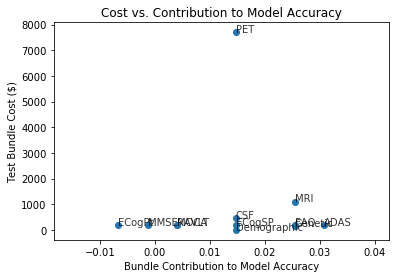

In [47]:
plt.scatter(acc_inc, test_C)
plt.title('Cost vs. Contribution to Model Accuracy')
plt.xlabel('Bundle Contribution to Model Accuracy')
plt.ylabel('Test Bundle Cost ($)')
for (i,x,y) in zip(bundles,acc_inc,test_C):
    plt.annotate(i,xy=(x,y), alpha=.8)
plt.show()

The ability of a test bundle to detect Alzheimer's earlier versus later is an added bonus to that bundle's utility. Detection timing and associated savings were estimated as detailed in the report. Below we plot the timing of detection (1=earliest possible detection, 2=medium timing, 3=latest possible detection) against bundle importance to the model.

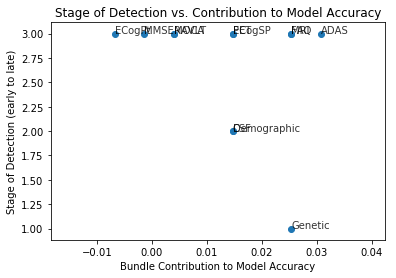

In [48]:
### CONSIDER WAYS TO REFORMAT THIS GRAPH AS 'EARLY' 'MEDIUM' 'LATE' INSTEAD OF CONTINUOUS Y AXIS


plt.scatter(acc_inc,det_T)
plt.title('Stage of Detection vs. Contribution to Model Accuracy')
plt.xlabel('Bundle Contribution to Model Accuracy')
plt.ylabel('Stage of Detection (early to late)')
for (i,x,y) in zip(bundles,acc_inc,det_T):
    plt.annotate(i,xy=(x,y), alpha=.8)
plt.show()

Below we combine cost and savings from early detection by considering the lack of savings in late detection as if it were an additional cost. The combined metric is therefore the sum of the absolute values of costs and savings for each predictor bundle.

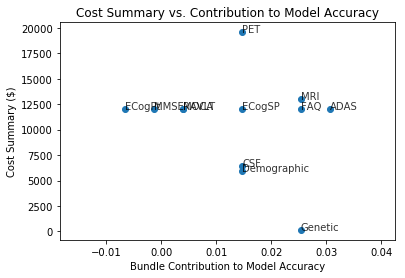

In [49]:
plt.scatter(acc_inc,tot_C)
plt.title('Cost Summary vs. Contribution to Model Accuracy')
plt.xlabel('Bundle Contribution to Model Accuracy')
plt.ylabel('Cost Summary ($)')
for (i,x,y) in zip(bundles,acc_inc,tot_C):
    plt.annotate(i,xy=(x,y), alpha=.8)
plt.show()

The genetic bundle (comprised only of APOE4 in this analysis) provides the greatest contribution to model accuracy for the least overall cost.